# Simulation of geometric-temporal

SEOYEON CHOI  
2022-12-28

> Simulation

https://pytorch-geometric-temporal.readthedocs.io/en/latest/modules/dataset.html#module-torch_geometric_temporal.dataset.chickenpox

### import

In [10]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

### 공식 홈페이지 예제

#### data

In [11]:
from torch_geometric_temporal.dataset import WikiMathsDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = WikiMathsDatasetLoader()

dataset = loader.get_dataset(lags=14)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

#### RecurrentGCN

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

#### Learn

In [13]:
from tqdm import tqdm

model = RecurrentGCN(node_features=14, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(1)):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 1/1 [00:11<00:00, 11.93s/it]

In [14]:
for time, snapshot in enumerate(train_dataset):
    _x = snapshot.x 
    _edge_index = snapshot.edge_index 
    _edge_attr = snapshot.edge_attr
    _y = snapshot.y
    break

In [15]:
_x.shape

In [18]:
snapshot.y.shape

-   1068개의 nodes
-   한 개의 node에 mapping된 차원의 수

In [7]:
_edge_index.shape

In [8]:
_edge_attr.shape

In [9]:
_y.shape

### 우리 예제

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [245]:
T = 100
N = 4 # number of Nodes
E = np.array([[0,1],[1,2],[2,3],[3,0]]).T
V = np.array([1,2,3,4])
AMP = np.array([3,2,1,2.2])
t = np.arange(0,T)
node_features = 1

In [13]:
f = np.stack([a*np.sin(2*t**2/1000)+np.random.normal(loc=0,scale=0.2,size=T) for a in AMP],axis=1).reshape(T,N,node_features)
f = torch.tensor(f).float()

In [14]:
f.shape

In [15]:
X = f[:99,:,:]
y = f[1:,:,:]

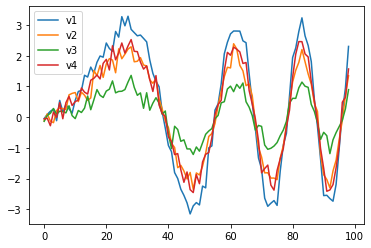

In [16]:
plt.plot(y[:,0,0],label="v1")
plt.plot(y[:,1,0],label="v2")
plt.plot(y[:,2,0],label="v3")
plt.plot(y[:,3,0],label="v4")
plt.legend()

In [17]:
edge_index = torch.tensor(E)
edge_attr = torch.tensor(np.array([1,1,1,1]),dtype=torch.float32)

In [18]:
_ee = enumerate(zip(X,y))

In [19]:
from tqdm import tqdm

model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X,y)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:16<00:00,  3.01it/s]

In [20]:
yhat = torch.stack([model(xt, edge_index, edge_attr) for xt in X]).detach().numpy()

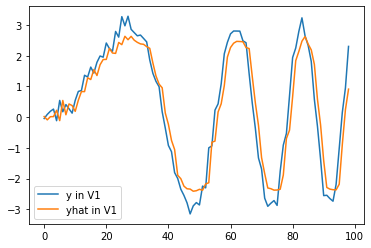

In [21]:
plt.plot(y[:,0,0],label="y in V1")
plt.plot(yhat[:,0,0],label="yhat in V1")
plt.legend()

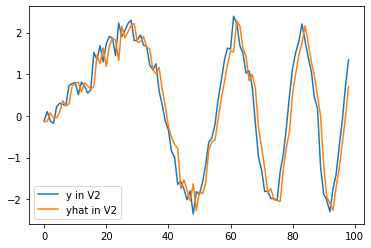

In [22]:
plt.plot(y[:,1,0],label="y in V2")
plt.plot(yhat[:,1,0],label="yhat in V2")
plt.legend()

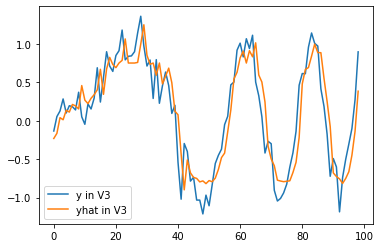

In [23]:
plt.plot(y[:,2,0],label="y in V3")
plt.plot(yhat[:,2,0],label="yhat in V3")
plt.legend()

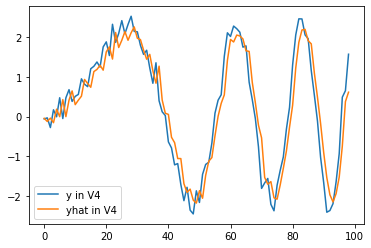

In [24]:
plt.plot(y[:,3,0],label="y in V4")
plt.plot(yhat[:,3,0],label="yhat in V4")
plt.legend()

### GNAR

In [35]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(GNAR)
library(igraph)

R[write to console]: Loading required package: igraph

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union


R[write to console]: Loading required package: wordcloud

R[write to console]: Loading required package: RColorBrewer


In [4]:
%%R
summary(fiveNet)

GNARnet with 5 nodes and 10 edges
 of equal length  1

In [5]:
%%R
edges <- as.matrix(fiveNet)
edges

     [,1] [,2] [,3] [,4] [,5]
[1,]    0    0    0    1    1
[2,]    0    0    1    1    0
[3,]    0    1    0    1    0
[4,]    1    1    1    0    0
[5,]    1    0    0    0    0

In [6]:
%%R
print(fiveNet)

GNARnet with 5 nodes 
edges:1--4 1--5 2--3 2--4 3--2 3--4 4--1 4--2 4--3 5--1 
     
 edges of each of length  1 

In [7]:
%%R
data("fiveNode")
answer <- GNARfit(vts = fiveVTS, net = fiveNet, alphaOrder = 2, betaOrder = c(1, 1))
answer

Model: 
GNAR(2,[1,1]) 

Call:
lm(formula = yvec ~ dmat + 0)

Coefficients:
 dmatalpha1  dmatbeta1.1   dmatalpha2  dmatbeta2.1  
    0.20624      0.50277      0.02124     -0.09523  


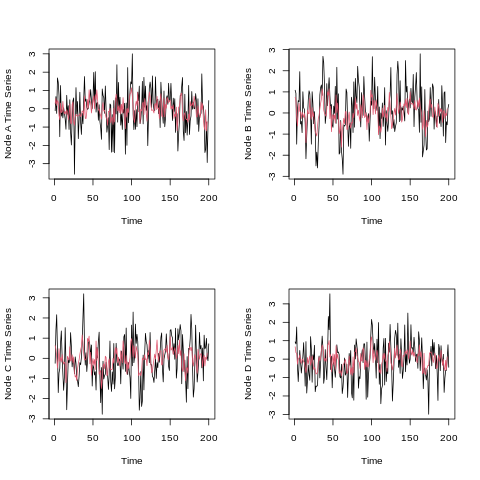

In [8]:
%%R
layout(matrix(c(1,2,3,4), 2, 2, byrow = TRUE))
plot(fiveVTS[, 1], ylab = "Node A Time Series")
lines(fitted(answer)[, 1], col = 2)
plot(fiveVTS[, 2], ylab = "Node B Time Series")
lines(fitted(answer)[, 2], col = 2)
plot(fiveVTS[, 3], ylab = "Node C Time Series")
lines(fitted(answer)[, 3], col = 2)
plot(fiveVTS[, 4], ylab = "Node D Time Series")
lines(fitted(answer)[, 4], col = 2)

In [9]:
%R -o fiveVTS
%R -o edges

-   node: 5
-   time 200

In [19]:
edges_tensor = torch.tensor(edges)

In [20]:
nonzero_indices = edges_tensor.nonzero()

In [21]:
fiveNet_edge = np.array(nonzero_indices).T
fiveNet_edge

In [22]:
fiveVTS.shape

In [23]:
T = 200
N = 5 # number of Nodes
E = fiveNet_edge
V = np.array([1,2,3,4,5])
t = np.arange(0,T)
node_features = 1

In [24]:
f = torch.tensor(fiveVTS).reshape(200,5,1).float()

In [25]:
X = f[:199,:,:]
y = f[1:,:,:]

In [26]:
edge_index = torch.tensor(E)
edge_attr = torch.tensor(np.array([1,1,1,1,1,1,1,1,1,1]),dtype=torch.float32)

In [27]:
_ee = enumerate(zip(X,y))

In [40]:
from tqdm import tqdm

model = RecurrentGCN(node_features=1, filters=8)

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X,y)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|█| 50/50 [00:34<00:00,  1.45it/

In [41]:
yhat = torch.stack([model(xt, edge_index, edge_attr) for xt in X]).detach().numpy()

In [42]:
yhat.shape

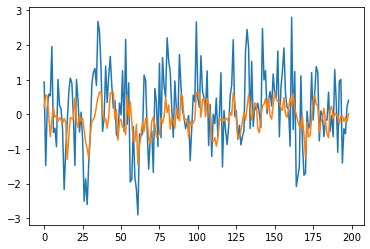

In [43]:
plt.plot(y[:,1])
plt.plot(yhat[:,1].data)

### Wind network time series

the data suite vswind that contains a number of R objects pertaining to
721 wind speeds taken at each of 102 weather stations in England and
Wales. The suite contains the vector time series vswindts, the
associated network vswindnet, a character vector of the weather station
location names in vswindnames and coordinates of the stations in the two
column matrix vswindcoords. The data originate from the UK Met Office
site http://wow.metoffice.gov.uk and full details can be found in the
vswind help file in the GNAR package.

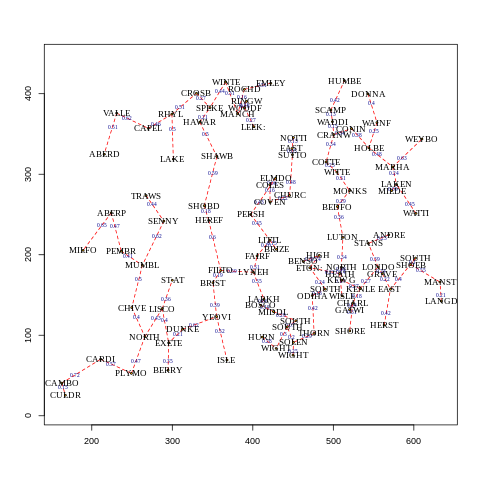

In [151]:
%%R
oldpar <- par(cex = 0.75)
windnetplot()
par(oldpar)

In [167]:
%%R
edges_wind <- as.matrix(vswindnet)

In [168]:
%R -o vswindts
%R -o edges_wind

-   nodes : 102
-   time step : 721

In [155]:
vswindts.shape

In [288]:
edges_wind.shape

In [214]:
edges_winds = torch.tensor(edges_wind)

In [215]:
nonzero_indices_wind = edges_winds.nonzero()

In [296]:
vswindnet_edge = np.array(nonzero_indices_wind).T
vswindnet_edge.shape

In [293]:
T = 721
N = 102 # number of Nodes
E = vswindnet_edge
V = np.array(range(101))
t = np.arange(0,T)
node_features = 1

In [297]:
f = torch.tensor(vswindts).reshape(721,102,1).float()

In [298]:
X = f[:720,:,:]
y = f[1:,:,:]

In [300]:
edge_index = torch.tensor(E)
edge_attr = torch.tensor(np.array([1]*202),dtype=torch.float32)

In [301]:
_ee = enumerate(zip(X,y))

In [302]:
from tqdm import tqdm

model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X,y)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [02:16<00:00,  2.73s/it]

In [303]:
yhat = torch.stack([model(xt, edge_index, edge_attr) for xt in X]).detach().numpy()

In [304]:
yhat.shape

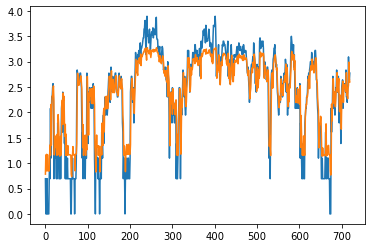

In [305]:
plt.plot(y[:,1])
plt.plot(yhat[:,1].data)

### OECD GDP

**해당예제는 GNAR 패키지에서 네트워크(엣지)를 맞추는 예제로서 나옴,
그렇기에 네트워크 존재하지 않아 연구 예제로서 사용하지 않을 예정**

이 데이터는 네트워크를 추정하여 fit 및 predict함

GOP growth rate time series

-   35 countries from the OECD website

-   time series : 1961 - 2013

-   T = 52

-   Nodes = 35

-   In this data set 20.8% (379 out of 1820) of the observations were
    missing due to some nodes not being included from the start.

In [157]:
%%R
library("fields")

In [158]:
%R -o gdpVTS

In [159]:
gdpVTS.shape

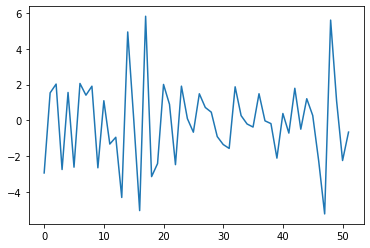

In [173]:
plt.plot(gdpVTS[:,1])